In [1]:
import Pkg

Pkg.activate(@__DIR__) # `@__DIR__` always gives the directory of where it was run

Pkg.add("Random")
Pkg.add("CairoMakie")
Pkg.add("Statistics")
Pkg.add("LinearAlgebra")

Pkg.status()

  Activating project at `c:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9`
   Resolving package versions...
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Project.toml`
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Project.toml`
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Project.toml`
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Project.toml`
  No Changes to `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Manifest.toml`


Status `C:\Users\nguye\Downloads\HighamNumericalSDEJulia\chapter9\Project.toml`
⌃ [13f3f980] CairoMakie v0.12.5
  [31c24e10] Distributions v0.25.110
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics v1.10.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\nguye\.julia\packages\Makie\rEu75\src\scenes.jl:227


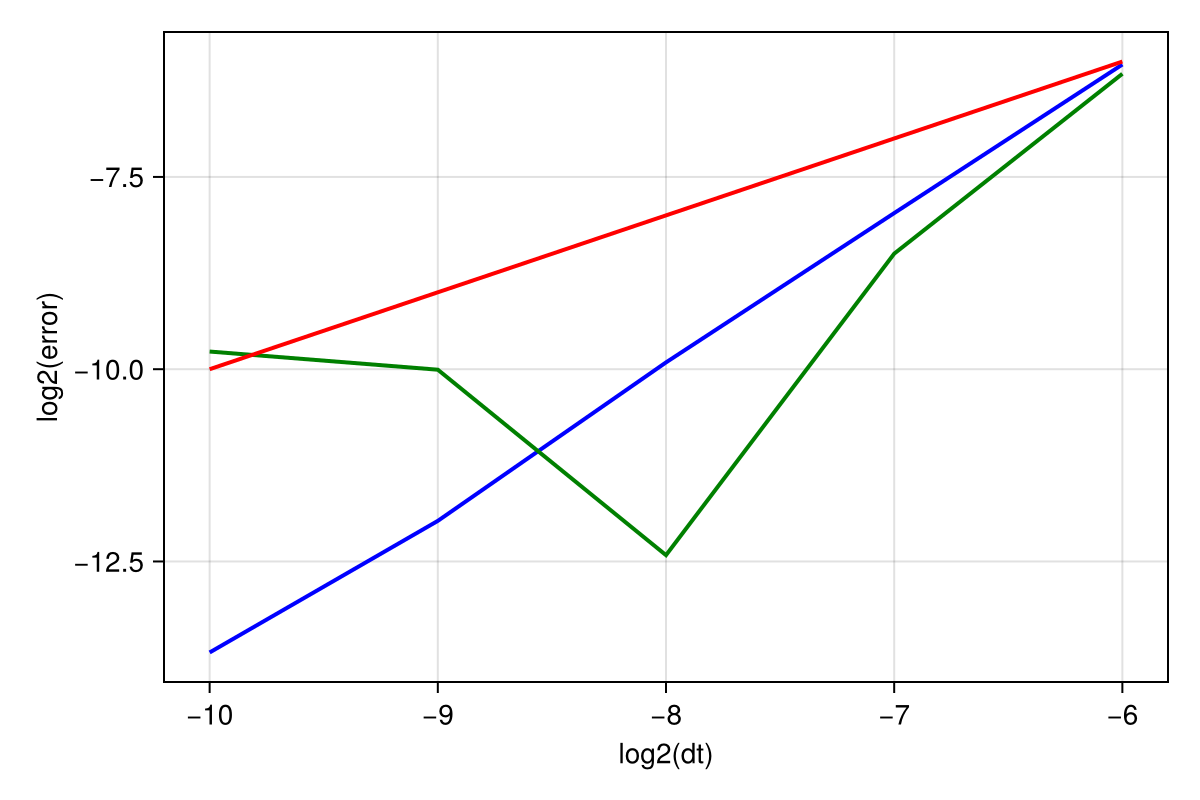

In [2]:
# Weak convergence of the Euler-Maruyama method

using Random, CairoMakie, Statistics

Random.seed!(1234)

mu = 2
sigma = 0.1

Xzero = 1

T = 1

N = 2^10
dt = T/N

reps = Int(5e4)
decreasing_number = 6


dW = sqrt(dt) * randn((reps, N))

Xpath = zeros(reps, N+1)
Xpath[:, 1] .= Xzero
for i in 1:N
    Xpath[:, i + 1] .= Xpath[:, i].*exp.((mu .- 0.5*sigma^2)*dt .+ sigma*dW[:, i])
end

Xem = Dict()

for i in 1:decreasing_number
    Xem[i - 1] = zeros(reps, N÷2^(i-1)+1)
end

for i in 1:decreasing_number
    Xem[i - 1][:, 1] .= Xzero

    dWTemp = zeros(reps, N÷2^(i-1))

    for j in 0:2^(i-1)-1
        dWTemp .+= dW[:, j+1:2^(i-1):end]
    end

    for j in 1:N÷2^(i-1)
        Xem[i - 1][:, j + 1] .= Xem[i - 1][:, j] .+ mu*Xem[i - 1][:, j]*dt*2^(i-1) .+ sigma*Xem[i - 1][:, j].*dWTemp[:, j]
    end
end

expectedPathEnd = mean(Xpath[:, end])
error = zeros(decreasing_number - 1)
errorExact = zeros(decreasing_number - 1)

for i in 1:decreasing_number-1
    error[i] = abs(mean(2 * Xem[i - 1][:, end] - Xem[i][:, end]) - expectedPathEnd)
    errorExact[i] = abs(mean(2 * Xem[i - 1][:, end] - Xem[i][:, end]) - exp(mu * T))
end

log2_error = log2.(error)
log2_errorExact = log2.(errorExact)

fig = Figure(resolution = (600, 400))

ax = Axis(fig[1, 1], xlabel = "log2(dt)", ylabel = "log2(error)")

lines!(ax, Int(log2(dt)):decreasing_number-1+Int(log2(dt)) - 1, log2_error, color = :blue, linewidth = 2)
# scatter!(ax, Int(log2(dt)):decreasing_number-1+Int(log2(dt)) - 1, log2_error, color = :blue)
lines!(ax, Int(log2(dt)):decreasing_number-1+Int(log2(dt)) - 1, log2_errorExact, color = :green, linewidth = 2)
lines!(ax, Int(log2(dt)):decreasing_number-1+Int(log2(dt)) - 1, Int(log2(dt)):decreasing_number-1+Int(log2(dt)) - 1, color = :red, linewidth = 2)

fig

In [3]:
[error, errorExact]

2-element Vector{Vector{Float64}}:
 [7.6044510298523e-5, 0.0002489328344301711, 0.0010381913113661767, 0.003987189282468329, 0.01521570819911755]
 [0.0011449032942909554, 0.0009720149701593073, 0.00018275649322330167, 0.0027662414778788502, 0.013994760394528072]

In [4]:
# Least square

using LinearAlgebra

A = hcat(ones(decreasing_number - 1), Int(log2(dt)):decreasing_number-1+Int(log2(dt))-1)
b = log2_error
bExact = log2_errorExact

x = A \ b
xExact = A \ bExact

println("The slope is ", x[2])
println("The intercept is ", x[1])
println("The residual is ", norm(A*x - b))
println("The slope (using exact expected) is ", xExact[2])
println("The intercept (using exact expected) is ", xExact[1])
println("The residual (using exact expected) is ", norm(A*xExact - bExact))
println("The diff between exact and computed end point is ", abs(expectedPathEnd - exp(mu*T)))

The slope is 1.929054698729397
The intercept is 5.51740337455984
The residual is 0.15847093065617823
The slope (using exact expected) is 0.873205493735381
The intercept (using exact expected) is -2.3847377876012272
The residual (using exact expected) is 3.647104439659049
The diff between exact and computed end point is 0.0012209478045894784
